In [2]:
import torch
import torchvision
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import cv2
import cv2
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report, precision_score, recall_score
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [4]:
labels = ['Healthy', 'Bacterial', 'Viral']
img_size = 150
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))     # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [9]:
healthy = os.listdir('../Dataset/CellData/chest_xray/train/NORMAL/')
healthy_dir = '../Dataset/CellData/chest_xray/train/NORMAL/'

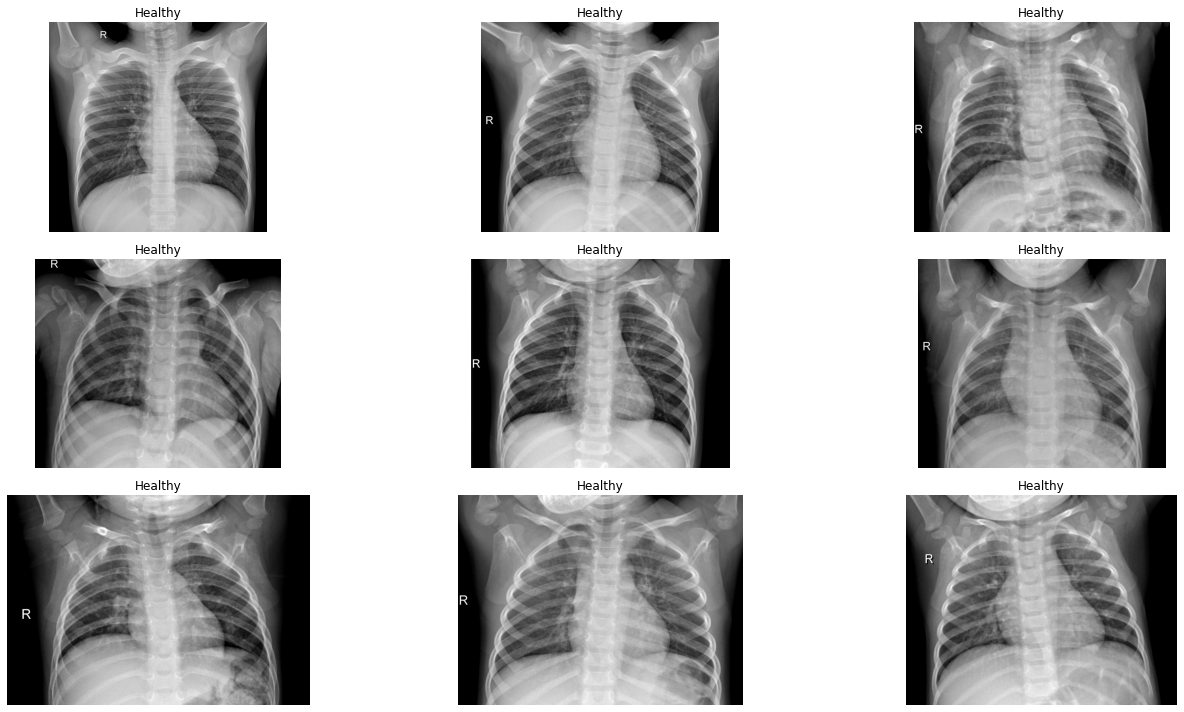

In [11]:
plt.figure(figsize = (20,10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(healthy_dir, healthy[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Healthy")
plt.tight_layout()

The dimensions are 2476 pixels height and 2572 pixels width
The maximum pixel value is 255.0000
The minimum pixel value is 0.0000
The mean value of the pixels is 120.9381
The standard deviation is 60.4879


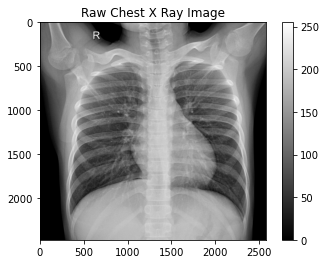

In [13]:
image = cv2.imread('../Dataset/CellData/chest_xray/train/NORMAL/NORMAL-1003233-0001.jpeg')
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions are {image.shape[0]} pixels height and {image.shape[1]} pixels width")
print(f"The maximum pixel value is {image.max():.4f}")
print(f"The minimum pixel value is {image.min():.4f}")
mean = image.mean()
std= image.std()
print(f"The mean value of the pixels is {mean:.4f}")
print(f"The standard deviation is {std:.4f}")


In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from PIL import Image

# Define your U-Net architecture
class UNet(nn.Module):
    # Define the layers and forward pass here
        def __init__(self, in_channels, out_channels):
            super(UNet, self).__init__()
            
            # Encoder
            self.encoder = nn.Sequential(
                nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            
            # Decoder
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        def forward(self, x):
            x1 = self.encoder(x)
            x2 = self.decoder(x1)
            return x2
# Define dataset class
class LungDataset(Dataset):
    def __init__(self, data_folder, mask_folder, transform=None):
        self.data_folder = data_folder
        self.mask_folder = mask_folder
        self.image_names = os.listdir(data_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.data_folder, image_name)
        mask_path = os.path.join(self.mask_folder, image_name)  # Assuming mask names match image names

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert mask to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Load your model
in_channels = 3
out_channels = 1
model = UNet(in_channels, out_channels)
model.load_state_dict(torch.load('../Dataset/masked/COVID-19_Radiography_Dataset/Viral/images/'))
model.eval()

# Set up data loader
transform = transforms.Compose([transforms.ToTensor()])
dataset = LungDataset(data_dir='../Dataset/masked/COVID-19_Radiography_Dataset/Bacterial/images', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Inference and save segmentation masks
output_folder = '../Dataset/masked/Segmnted'
os.makedirs(output_folder, exist_ok=True)

with torch.no_grad():
    for i, (input_image, _) in enumerate(dataloader):
        # Perform inference
        output_mask = model(input_image)
        output_mask = (output_mask > 0.5).float()  # Applying threshold for binary mask
       
        # Convert tensor to numpy array
        output_mask_np = output_mask.cpu().numpy()[0, 0, :, :]  # Assuming batch size is 1
       
        # Save the segmentation mask
        mask_filename = f'mask_{i}.png'
        mask_filepath = os.path.join(output_folder, mask_filename)
        output_mask_pil = Image.fromarray((output_mask_np * 255).astype(np.uint8))
        output_mask_pil.save(mask_filepath)

print("Segmentation masks saved.")

PermissionError: [Errno 13] Permission denied: '../Dataset/masked/COVID-19_Radiography_Dataset/Viral/images/'

In [10]:
import os
import cv2
import torch
import torchvision.transforms as transforms
from torchvision import models

# Load pre-trained U-Net model
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.eval()

input_folder = "../Dataset/masked/COVID-19_Radiography_Dataset/Bacterial/images/"
output_folder = "../Dataset/masked/segmented/"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Preprocessing transforms
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Iterate through images in input folder
for image_name in os.listdir(input_folder):
    image_path = os.path.join(input_folder, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = preprocess(image).unsqueeze(0)

    # Perform segmentation
    with torch.no_grad():
        output = model(image_tensor)['out']

    # Post-process masks (e.g., thresholding)
    mask = output.argmax(1).squeeze().cpu().numpy()  # Convert to numpy array

    # Save segmented image
    output_mask_path = os.path.join(output_folder, image_name)
    cv2.imwrite(output_mask_path, mask * 255)  # Assuming mask values are in [0, 1]

print("Segmentation and saving complete.")

c:\Users\HP\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [8]:
import torch
import torch.nn as nn

# Define the encoder and decoder blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Encoder
        self.encoder_blocks = nn.ModuleList([
            ConvBlock(in_channels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
            ConvBlock(512, 1024)
        ])
       
        # Decoder
        self.decoder_blocks = nn.ModuleList([
            ConvBlock(1024, 512),
            ConvBlock(512, 256),
            ConvBlock(256, 128),
            ConvBlock(128, 64),
            ConvBlock(64, out_channels)
        ])
       
        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        skip_connections = []
       
        # Encoder
        for block in self.encoder_blocks:
            x = block(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(kernel_size=2)(x)
       
        # Decoder
        for i, block in enumerate(self.decoder_blocks):
            x = self.upsample(x)
            x = torch.cat([x, skip_connections[-(i + 1)]], dim=1)
            x = block(x)
       
        return x
    

# Instantiate the model
in_channels = 3  # Number of input channels (e.g., for RGB images)
out_channels = 1  # Number of output channels (e.g., for segmentation mask)
model = UNet(in_channels, out_channels)

# Print model summary
print(model)


UNet(
  (encoder_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from your_dataset_module import CustomDataset  # Import your dataset class
from unet_model import UNet  # Import your UNet model

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 4
num_epochs = 20
learning_rate = 0.001

# Data loading and augmentation
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = CustomDataset(data_dir='path_to_training_images_folder', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Instantiate the model
in_channels = 3
out_channels = 1
model = UNet(in_channels, out_channels).to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
       
        # Forward pass
        outputs = model(images)
       
        # Compute loss
        loss = criterion(outputs, masks)
       
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the trained model
torch.save(model.state_dict(), 'unet_model.pth')


ModuleNotFoundError: No module named 'your_dataset_module'